In [1]:
height = 96
width = 1408
max_text_length = 0
batch_size = 32
learning_rate = 0.0005
train_epochs = 1000
train_workers = 20
vocab=""

In [2]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers as layers

2024-04-14 05:31:14.307353: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-14 05:31:14.307460: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-14 05:31:14.434938: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import os
from tqdm import tqdm
import csv



# Paths for datasets
sentences_txt_path = "/kaggle/input/iamsentences/metadata/sentences.txt"
sentences_folder_path = "/kaggle/input/iamsentences/dataset"

# Load and process dataset
dataset, vocab, max_len = [], set(), 0
words = open(sentences_txt_path, "r").readlines()
for line in tqdm(words):
    if line.startswith("#"):
        continue

    line_split = line.split(" ")
    if line_split[2] == "err":
        continue

    folder1 = line_split[0][:3]
    folder2 = "-".join(line_split[0].split("-")[:2])
    file_name = line_split[0] + ".png"
    label = line_split[-1].rstrip("\n")

    # replace "|" with " " in label
    label = label.replace("|", " ")

    rel_path = os.path.join(sentences_folder_path, file_name)
    if not os.path.exists(rel_path):
        print(f"File not found: {rel_path}")
        continue

    dataset.append([rel_path, label])
    max_len = max(max_len, len(label))


max_text_length = max_len



csv_file_path = "data.csv"

# Write the data to the CSV file with labeled columns
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write the header row with labeled columns
    writer.writerow(["path", "label"])
    
    # Write the data
    writer.writerows(dataset)

print("CSV file has been created successfully.")



100%|██████████| 16777/16777 [00:14<00:00, 1143.90it/s]

CSV file has been created successfully.


In [5]:
data = pd.read_csv("/kaggle/working/data.csv")

In [6]:
data.head()

,path,label
0,/kaggle/input/iamsentences/dataset/a01-000u-s0...,A MOVE to stop Mr. Gaitskell from
1,/kaggle/input/iamsentences/dataset/a01-000u-s0...,nominating any more Labour life Peers
2,/kaggle/input/iamsentences/dataset/a01-000u-s0...,is to be made at a meeting of Labour
3,/kaggle/input/iamsentences/dataset/a01-000u-s0...,put down a resolution on the subject
4,/kaggle/input/iamsentences/dataset/a01-000u-s0...,P for Manchester Exchange .


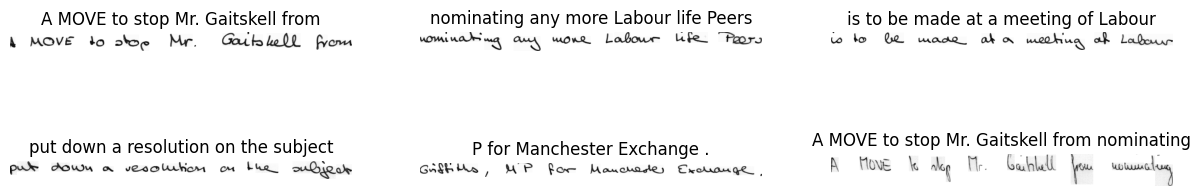

In [7]:
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = data.loc[i, 'path']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(data.loc[i, 'label'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [8]:
print("Number of NaNs in train set      : ", data['label'].isnull().sum())

Number of NaNs in train set      :  3


In [9]:
data.dropna(axis=0, inplace=True)

In [10]:
data['label'] = data['label'].str.upper()

In [11]:
data.reset_index(inplace = True, drop=True) 

In [12]:
train_y_labels_max=0
train_y_labels_sum=0
train_y_labels_count_freq={}
for i in range(len(data)):
    freq=len(data.loc[i,'label'])
    if freq in train_y_labels_count_freq:
        train_y_labels_count_freq[freq]=train_y_labels_count_freq[freq]+1
    else:
        train_y_labels_count_freq[freq]=1
    if freq>train_y_labels_max:
        train_y_labels_max=freq
    train_y_labels_sum = train_y_labels_sum+freq

print('max len:', train_y_labels_max)
print('avg len:', train_y_labels_sum/len(data))

max len: 93
avg len: 34.388991477272725


<BarContainer object of 79 artists>

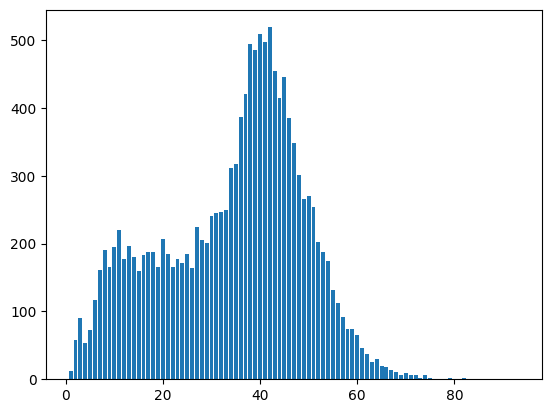

In [13]:
plt.bar(list(train_y_labels_count_freq.keys()),list(train_y_labels_count_freq.values()))

In [14]:
def augment_image(image):
    # Random Gaussian Blur
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 0)  # Horizontal flip
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)  # Vertical flip
        
    if np.random.rand() < 0.7:
        kernel_size = tuple(np.random.randint(3, 6, 2) * 2 + 1)  
        #kernel_size = tuple(np.random.randint(3, 12, 2) * 2 + 1)  
        image = cv2.GaussianBlur(image, kernel_size, 0)

    # Random Brightness Adjustment
    if np.random.rand() < 0.7:
        brightness_factor = np.random.uniform(0.8, 1.2)
        image = np.clip(image * brightness_factor, 0, 255).astype(np.uint8)

    # Random Contrast Adjustment
    if np.random.rand() < 0.7:
        contrast_factor = np.random.uniform(0.3, 1.5)
        image = np.clip((image - 127.5) * contrast_factor + 127.5, 0, 255).astype(np.uint8)

    # Random Saturation Adjustment
    if np.random.rand() < 0.7:
        saturation_factor = np.random.uniform(0.3, 1.5)
        hsv_image = cv2.cvtColor(cv2.cvtColor(image, cv2.COLOR_GRAY2BGR), cv2.COLOR_BGR2HSV)
        hsv_image[..., 1] = np.clip(hsv_image[..., 1] * saturation_factor, 0, 255)
        # Extract the value (brightness) channel from the HSV image
        image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)[:, :, 2]
    return image

In [15]:
def resize_or_pad_image(image, target_height=64, target_width=512):
    image = cv2.resize(image, (target_width, target_height))
    return image

In [16]:
def preprocess(img):
    (h, w) = img.shape    
    final_image = resize_or_pad_image(img)
    return cv2.rotate(final_image, cv2.ROTATE_90_CLOCKWISE)

In [17]:
import cv2

# Load the image
flag=0
for i in range(1,100):
    image = cv2.imread(data.loc[i,'path'])
    image = resize_or_pad_image(image)
    image_shape = image.shape

    print("Shape of the image:", image_shape)

Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of t

1
1
1


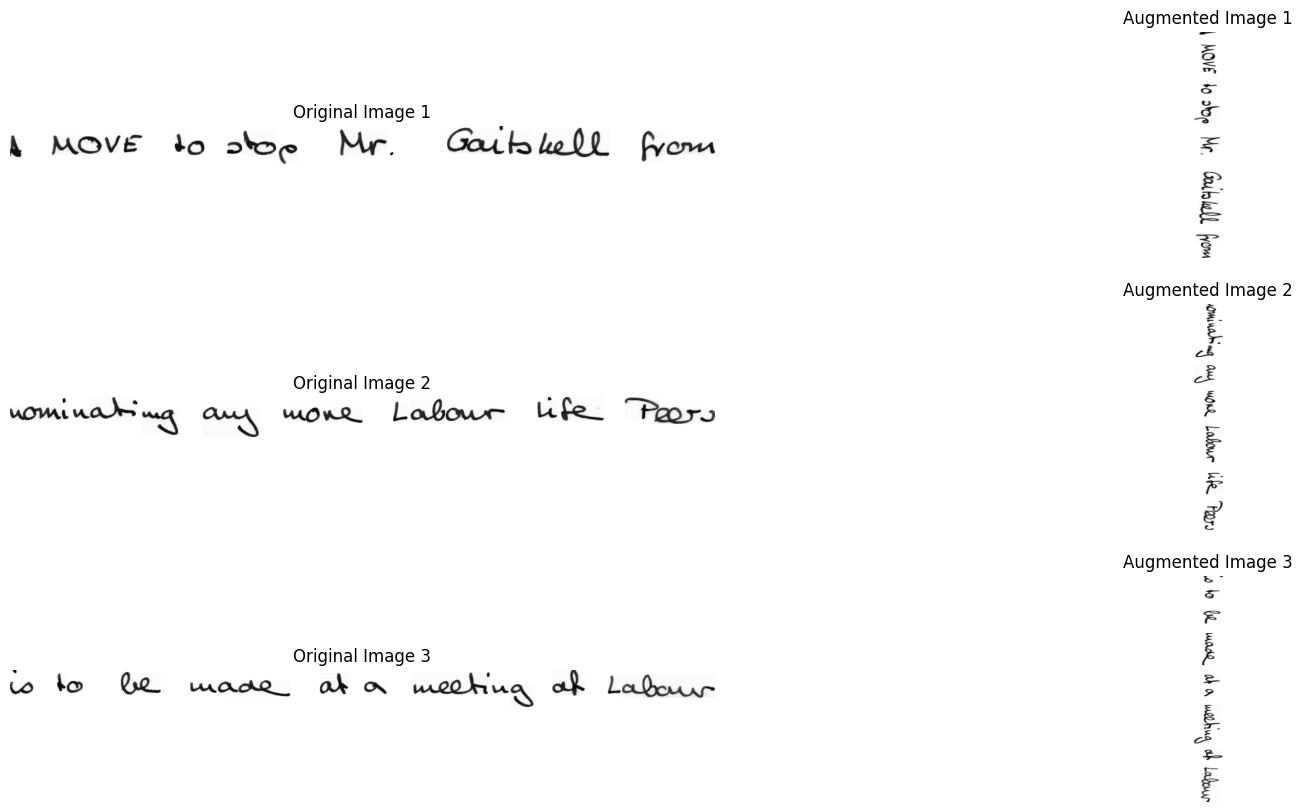

In [18]:
img_paths = ['/kaggle/input/iamsentences/dataset/a01-000u-s00-00.png',
             '/kaggle/input/iamsentences/dataset/a01-000u-s00-01.png',
             '/kaggle/input/iamsentences/dataset/a01-000u-s00-02.png']

# Plot the first three images and their augmented versions
plt.figure(figsize=(20, 10))

for i in range(3):
    img_path = img_paths[i]
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    aug_img = preprocess(img)
    print(1)
    plt.subplot(3, 2, i * 2 + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Original Image {i + 1}')
    plt.axis('off')

    plt.subplot(3, 2, i * 2 + 2)
    plt.imshow(aug_img, cmap='gray')
    plt.title(f'Augmented Image {i + 1}')
    plt.axis('off')

plt.show()

In [19]:
len(data)

14080

In [20]:
train_size = 12080
valid_size = 1000
test_size = 1000

In [21]:
img_aug_cnt=0

In [22]:
train_x = []

for i in range(train_size):
    img_dir = data.loc[i, 'path']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    if random.randint(0, 10) in [1,2,3]:
        image= augment_image(image)
        img_aug_cnt=img_aug_cnt+1
    image = preprocess(image)
    image = image/255.
    train_x.append(image)

In [23]:
valid_x = []

for i in range(train_size,train_size+valid_size):
    img_dir = data.loc[i, 'path']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

In [24]:
test_x = []

for i in range(train_size+valid_size,train_size+test_size+valid_size):
    img_dir = data.loc[i, 'path']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    test_x.append(image)

In [25]:
print('train:',len(train_x),'valid:',len(valid_x),'test:',len(test_x))

train: 12080 valid: 1000 test: 1000


In [26]:
np.asarray(train_x).shape

(12080, 512, 64)

In [27]:
train_x = np.array(train_x).reshape(-1, 512, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 512, 64, 1)
test_x = np.array(test_x).reshape(-1, 512, 64, 1)

In [28]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-,!?.' "
max_str_len = 95 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 128 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        ind=alphabets.find(ch)
        if ind != -1:
            label_num.append(ind)
        else:
            label_num.append(0)
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [29]:
name = 'JEBASTIN'
print(name, '\n',label_to_num(name))

JEBASTIN 
 [ 9  4  1  0 18 19  8 13]


In [30]:
train_y = np.ones([train_size,max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(data.loc[i, 'label'])
    train_y[i, 0:len(data.loc[i, 'label'])]= label_to_num(data.loc[i, 'label'])    

In [31]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(train_size,train_size+valid_size):
    valid_label_len[i-train_size] = len(data.loc[i, 'label'])
    valid_y[i-train_size, 0:len(data.loc[i, 'label'])]= label_to_num(data.loc[i, 'label'])    

In [32]:
test_y = np.ones([test_size, max_str_len]) * -1
test_label_len = np.zeros([test_size, 1])
test_input_len = np.ones([test_size, 1]) * (num_of_timestamps-2)
test_output = np.zeros([test_size])

for i in range(train_size+valid_size,train_size+valid_size+test_size):
    test_label_len[i-(train_size+valid_size)] = len(data.loc[i, 'label'])
    test_y[i-(train_size+valid_size), 0:len(data.loc[i, 'label'])]= label_to_num(data.loc[i, 'label']) 

In [33]:
print('True label : ',data.loc[100, 'label'] , '\ntrain_y : ',train_y[100],'\ntrain_label_len : ',train_label_len[100], 
      '\ntrain_input_len : ', train_input_len[100])

True label :  THE TALKS FALL THROUGH . 
train_y :  [19.  7.  4. 32. 19.  0. 11. 10. 18. 32.  5.  0. 11. 11. 32. 19.  7. 17.
 14. 20.  6.  7. 32. 30. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1.] 
train_label_len :  [24.] 
train_input_len :  [126.]


In [34]:
# from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Reshape, Dense, Bidirectional, LSTM
# from tensorflow.keras.models import Model
# from tensorflow.keras import regularizers

# # Define input layer
# input_data = Input(shape=(512, 64, 1), name='input')

# # Convolutional layers
# inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(input_data)  
# inner = BatchNormalization()(inner)
# inner = Activation('relu')(inner)
# inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

# inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(inner)
# inner = BatchNormalization()(inner)
# inner = Activation('relu')(inner)
# inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
# inner = Dropout(0.3)(inner)

# inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(inner)
# inner = Conv2D(128, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(inner)
# inner = BatchNormalization()(inner)
# inner = Activation('relu')(inner)
# inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
# inner = Dropout(0.3)(inner)

# # CNN to RNN
# inner = Reshape(target_shape=((128, 1024)), name='reshape')(inner)
# inner = Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01), name='dense1')(inner)

# # RNN layers
# inner = Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=regularizers.l2(0.01)), name='lstm1')(inner)
# inner = Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=regularizers.l2(0.01)), name='lstm2')(inner)

# # Output laye
# inner = Dense(num_of_characters, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01), name='dense2')(inner)
# y_pred = Activation('softmax', name='softmax')(inner)

# # Create model
# model = Model(inputs=input_data, outputs=y_pred)
# model.summary()


In [35]:
# squeezenet
from tensorflow.keras.layers import Concatenate, Conv2D, MaxPooling2D, Flatten, Reshape, Dense, LSTM, Bidirectional, Input, Activation

def fire_module(x, fire_id, squeeze=16, expand=64):
    """
    Create a fire module with squeeze and expand layers.
    """
    squeeze_channels = squeeze
    expand1_channels = expand
    expand3_channels = expand

    # Squeeze layer
    squeeze_layer = Conv2D(squeeze_channels, (1, 1), activation='relu', padding='same', name='fire{}_squeeze'.format(fire_id))(x)

    # Expand layer 1x1
    expand1_layer = Conv2D(expand1_channels, (1, 1), activation='relu', padding='same', name='fire{}_expand1x1'.format(fire_id))(squeeze_layer)

    # Expand layer 3x3
    expand3_layer = Conv2D(expand3_channels, (3, 3), activation='relu', padding='same', name='fire{}_expand3x3'.format(fire_id))(squeeze_layer)

    # Concatenate the outputs
    output = Concatenate(axis=-1, name='fire{}_concatenate'.format(fire_id))([expand1_layer, expand3_layer])

    return output

# Define input shape
input_data = Input(shape=(512, 64, 1), name='input')

# SqueezeNet architecture
conv1 = Conv2D(64, (3, 3), strides=(2, 2), activation='relu', padding='valid', name='conv1')(input_data)
pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(conv1)

fire2 = fire_module(pool1, fire_id=2, squeeze=16, expand=64)
fire3 = fire_module(fire2, fire_id=3, squeeze=16, expand=64)
pool3 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(fire3)
pool3 = Dropout(0.4)(pool3)

fire4 = fire_module(pool3, fire_id=4, squeeze=32, expand=128)
fire5 = fire_module(fire4, fire_id=5, squeeze=32, expand=128)
pool5 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(fire5)
pool5 = Dropout(0.4)(pool5)

fire6 = fire_module(pool5, fire_id=6, squeeze=48, expand=192)
fire7 = fire_module(fire6, fire_id=7, squeeze=48, expand=192)
fire8 = fire_module(fire7, fire_id=8, squeeze=64, expand=256)
fire8 = Dropout(0.4)(fire8)

# Flatten and Dense layers
flatten = Flatten(name='flatten')(fire8)
# dense1 = Dense(512, activation='relu', name='dense1')(flatten)

# Reshape for LSTM
reshaped_output = Reshape(target_shape=(128, 372))(flatten)
inner = Dense(128, activation='relu', kernel_initializer='he_normal', name='dense1')(reshaped_output)

# LSTM layers
lstm1 = Bidirectional(LSTM(256, return_sequences=True), name='lstm1')(inner)
lstm2 = Bidirectional(LSTM(256, return_sequences=True), name='lstm2')(lstm1)

# Output layer
y_pred = Dense(num_of_characters, activation='softmax', name='output')(lstm2)

# Create model
model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 512, 64,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 255, 31,   │        640 │ input[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 127, 15,   │          0 │ conv1[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fire2_squeeze       │ (None, 127, 15,   │      1,040 │ pool1[0][0]       │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fire2_expand1x1     │ (None, 127, 15,   │      1,088 │ fire2_squeeze[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fire2_expand3x3     │ (None, 127, 15,   │      9,280 │ fire2_squeeze[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fire2_concatenate   │ (None, 127, 15,   │          0 │ fire2_expand1x1[… │
│ (Concatenate)       │ 128)              │            │ fire2_expand3x3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fire3_squeeze       │ (None, 127, 15,   │      2,064 │ fire2_concatenat… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fire3_expand1x1     │ (None, 127, 15,   │      1,088 │ fire3_squeeze[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fire3_expand3x3     │ (None, 127, 15,   │      9,280 │ fire3_squeeze[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fire3_concatenate   │ (None, 127, 15,   │          0 │ fire3_expand1x1[… │
│ (Concatenate)       │ 128)              │            │ fire3_expand3x3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool3               │ (None, 63, 7,     │          0 │ fire3_concatenat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 63, 7,     │          0 │ pool3[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fire4_squeeze       │ (None, 63, 7, 32) │      4,128 │ dropout[0][0]     │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fire4_expand1x1     │ (None, 63, 7,     │      4,224 │ fire4_squeeze[0]… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fire4_expand3x3     │ (None, 63, 7,     │     36,992 │ fire4_squeeze[0]… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fire4_concatenate   │ (None, 63, 7,     │          0 │ fire4_expand1x1[

 Total params: 2,952,738 (11.26 MB)

 Trainable params: 2,952,738 (11.26 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# import tensorflow as tf
# from tensorflow.keras.applications import MobileNetV2
# from tensorflow.keras.layers import Input, Concatenate, Flatten, Dropout, Dense, Reshape, Bidirectional, LSTM
# from tensorflow.keras.models import Model

# # Define input layer
# input_data = Input(shape=(512, 64, 1), name='input')
# x = Concatenate()([input_data, input_data, input_data])

# # Load MobileNetV2 without the top (classification) layers
# mobilenet_v2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(512, 64, 3))

# # Define L2 regularizer
# penalty = 0.01
# regularizer = tf.keras.regularizers.l2(penalty)

# # Apply L2 regularization to MobileNetV2 layers
# for layer in mobilenet_v2.layers:
#     for attr in ['kernel_regularizer']:
#         if hasattr(layer, attr):
#             setattr(layer, attr, regularizer)

# # Pass input through MobileNetV2
# mobilenet_output = mobilenet_v2(x)

# # Additional layers after feature extraction
# inner = Flatten()(mobilenet_output)
# inner = Dropout(0.4)(inner)  # Dropout regularization

# # CNN to RNN
# inner = Reshape(target_shape=(128, 320), name='reshape')(inner)
# inner = Dense(128, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

# # LSTM layers
# inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm1')(inner)
# inner = Dropout(0.4)(inner)  # Dropout regularization

# inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm2')(inner)
# inner = Dropout(0.4)(inner)  # Dropout regularization

# # Output layer
# y_pred = Dense(num_of_characters, activation='softmax', name='output')(inner)

# # Create model
# model = Model(inputs=input_data, outputs=y_pred)
# model.summary()

In [37]:
# # mobilenetv2
# from tensorflow.keras.applications import MobileNetV2
# from tensorflow.keras.layers import Concatenate,Flatten

# input_data = Input(shape=(512, 64, 1), name='input')
# x = Concatenate()([input_data, input_data, input_data])

# # Load MobileNetV2 without the top (classification) layers
# mobilenet_v2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(512, 64, 3))

# # Pass input through MobileNetV2
# mobilenet_output = mobilenet_v2(x)

# # Additional layers after feature extraction
# inner = Flatten()(mobilenet_output)
# inner = Dropout(0.4)(inner)

# # inner = Dense(64, activation='relu', name='dense1')(inner)

# # CNN to RNN
# inner = Reshape(target_shape=(128, 320), name='reshape')(inner)
# inner = Dense(128, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

# # LSTM layers
# inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm1')(inner)

# inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm2')(inner)

# # Output layer
# y_pred = Dense(num_of_characters, activation='softmax', name='output')(inner)

# # Create model
# model = Model(inputs=input_data, outputs=y_pred)
# model.summary()

In [38]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [39]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [40]:
model_final.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 512, 64,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 255, 31,   │        640 │ input[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 127, 15,   │          0 │ conv1[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fire2_squeeze       │ (None, 127, 15,   │      1,040 │ pool1[0][0]       │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fire2_expand1x1     │ (None, 127, 15,   │      1,088 │ fire2_squeeze[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fire2_expand3x3     │ (None, 127, 15,   │      9,280 │ fire2_squeeze[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fire2_concatenate   │ (None, 127, 15,   │          0 │ fire2_expand1x1[… │
│ (Concatenate)       │ 128)              │            │ fire2_expand3x3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fire3_squeeze       │ (None, 127, 15,   │      2,064 │ fire2_concatenat… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fire3_expand1x1     │ (None, 127, 15,   │      1,088 │ fire3_squeeze[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fire3_expand3x3     │ (None, 127, 15,   │      9,280 │ fire3_squeeze[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fire3_concatenate   │ (None, 127, 15,   │          0 │ fire3_expand1x1[… │
│ (Concatenate)       │ 128)              │            │ fire3_expand3x3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool3               │ (None, 63, 7,     │          0 │ fire3_concatenat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 63, 7,     │          0 │ pool3[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fire4_squeeze       │ (None, 63, 7, 32) │      4,128 │ dropout[0][0]     │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fire4_expand1x1     │ (None, 63, 7,     │      4,224 │ fire4_squeeze[0]… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fire4_expand3x3     │ (None, 63, 7,     │     36,992 │ fire4_squeeze[0]… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fire4_concatenate   │ (None, 63, 7,     │          0 │ fire4_expand1x1[

 Total params: 2,952,738 (11.26 MB)

 Trainable params: 2,952,738 (11.26 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
optimizer = Adam(learning_rate=0.0005)
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

history=model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=120, batch_size=64,verbose=1)
# ,callbacks=[early_stopping]

Epoch 1/120


2024-04-14 05:33:56.194496: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_3_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


189/189 ━━━━━━━━━━━━━━━━━━━━ 44s 161ms/step - loss: 145.2347 - val_loss: 95.1725
Epoch 2/120
189/189 ━━━━━━━━━━━━━━━━━━━━ 28s 147ms/step - loss: 108.3054 - val_loss: 95.6168
Epoch 3/120
189/189 ━━━━━━━━━━━━━━━━━━━━ 28s 148ms/step - loss: 106.9099 - val_loss: 90.2825
Epoch 4/120
189/189 ━━━━━━━━━━━━━━━━━━━━ 28s 148ms/step - loss: 103.9514 - val_loss: 84.5219
Epoch 5/120
189/189 ━━━━━━━━━━━━━━━━━━━━ 28s 148ms/step - loss: 94.9007 - val_loss: 79.0254
Epoch 6/120
189/189 ━━━━━━━━━━━━━━━━━━━━ 28s 148ms/step - loss: 91.0343 - val_loss: 75.3995
Epoch 7/120
189/189 ━━━━━━━━━━━━━━━━━━━━ 28s 149ms/step - loss: 88.3391 - val_loss: 74.3458
Epoch 8/120
189/189 ━━━━━━━━━━━━━━━━━━━━ 28s 148ms/step - loss: 87.0592 - val_loss: 74.4105
Epoch 9/120
189/189 ━━━━━━━━━━━━━━━━━━━━ 28s 148ms/step - loss: 85.8544 - val_loss: 71.7004
Epoch 10/120
189/189 ━━━━━━━━━━━━━━━━━━━━ 28s 148ms/step - loss: 84.6702 - val_loss: 71.0441
Epoch 11/120
189/189 ━━━━━━━━━━━━━━━━━━━━ 28s 149ms/step - loss: 83.4565 - val_loss: 74

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


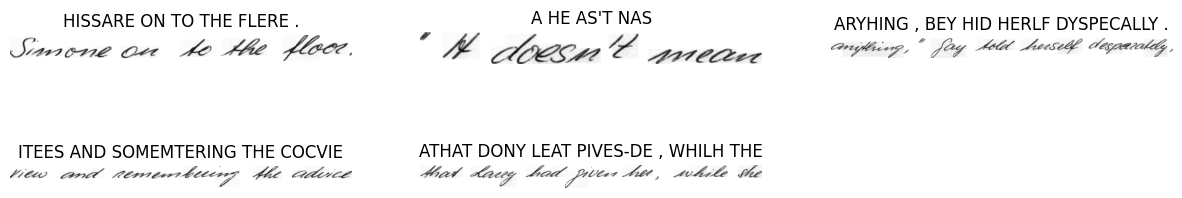

In [42]:
# test = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_test_v2.csv')

plt.figure(figsize=(15, 10))
for i in range(0,5):
    ax = plt.subplot(2, 3, i+1)
    img_dir = data.loc[i+train_size+valid_size, 'path']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 512, 64, 1))
    decoded = tf.keras.backend.get_value(tf.keras.backend.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


(-0.5, 509.5, 379.5, -0.5)

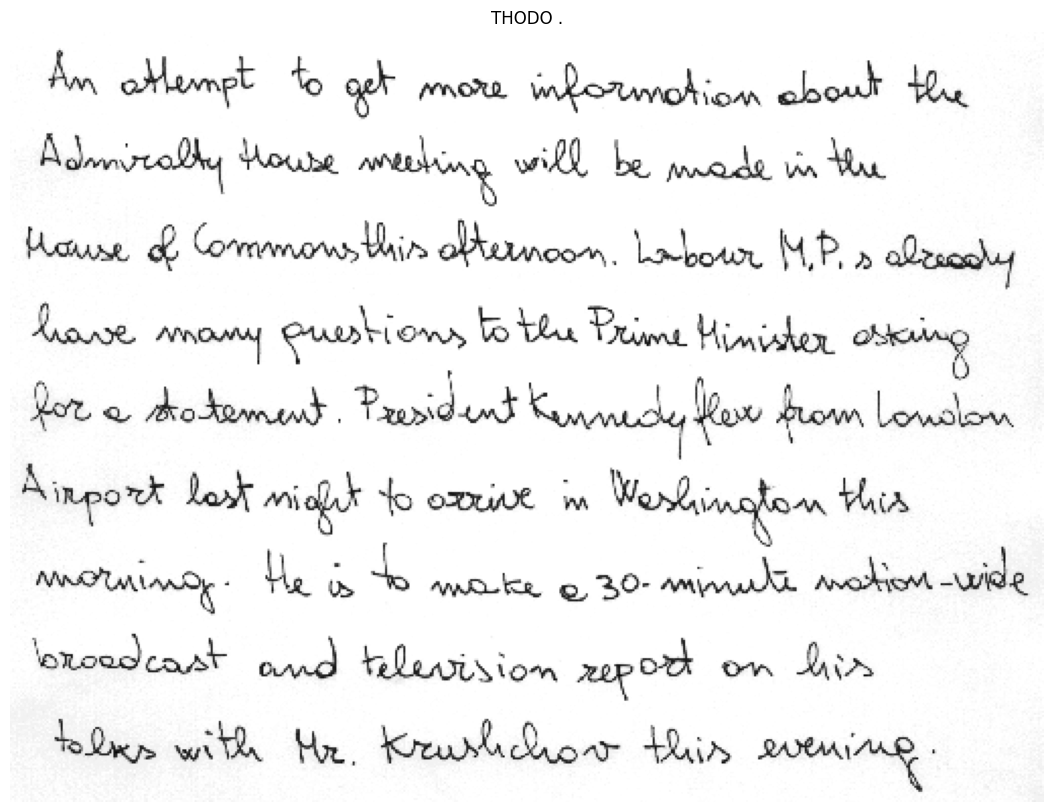

In [43]:
plt.figure(figsize=(15, 10))

#     img_dir = data.loc[i+train_size+valid_size, 'path']
image = cv2.imread("/kaggle/input/custom-imgs/img.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')
    
image = preprocess(image)
image = image/255.
pred = model.predict(image.reshape(1, 512, 64, 1))
decoded = tf.keras.backend.get_value(tf.keras.backend.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
plt.title(num_to_label(decoded[0]), fontsize=12)
plt.axis('off')
    


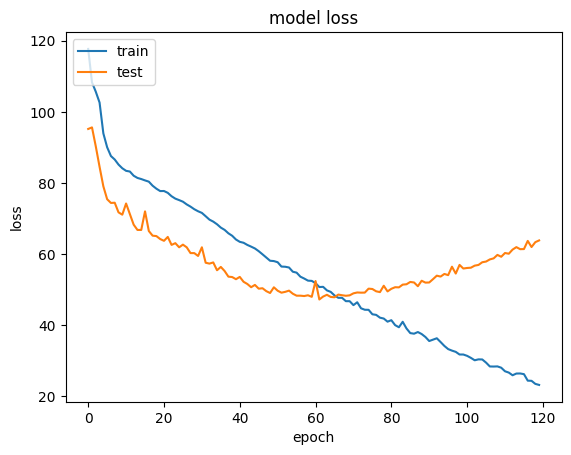

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [45]:
preds = model.predict(test_x)
decoded = tf.keras.backend.get_value(tf.keras.backend.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(test_size):
    prediction.append(num_to_label(decoded[i]))

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step


In [46]:
y_true = data.loc[train_size+valid_size:train_size+valid_size+test_size, 'label']


def calculate_accuracy(y_true, y_pred):
    total_words = 0
    correct_words = 0
    total_characters = 0
    correct_characters = 0

    for true_sentence, pred_sentence in zip(y_true, y_pred):
        true_words = true_sentence.split()
        pred_words = pred_sentence.split()
        true_characters = list(true_sentence)
        pred_characters = list(pred_sentence)

        total_words += len(true_words)
        total_characters += len(true_characters)

        # Calculate word accuracy
        for true_word, pred_word in zip(true_words, pred_words):
            if true_word == pred_word:
                correct_words += 1

        # Calculate character accuracy
        for true_char, pred_char in zip(true_characters, pred_characters):
            if true_char == pred_char:
                correct_characters += 1

    word_accuracy = correct_words / total_words if total_words > 0 else 0
    character_accuracy = correct_characters / total_characters if total_characters > 0 else 0

    return word_accuracy, character_accuracy


word_accuracy, character_accuracy = calculate_accuracy(y_true, prediction)
print("Word Accuracy:", word_accuracy)
print("Character Accuracy:", character_accuracy)


Word Accuracy: 0.21451343555488084
Character Accuracy: 0.14383539520010336


In [47]:
model.save('sentence_model.h5')

ValueError: Unable to synchronously create dataset (name already exists)